In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm


In [2]:
import torch
nltk.download('stopwords') #This downloads a list of common English words (like "the", "a", "is", "are", etc.) that are often removed from text data during preprocessing.
nltk.download('punkt_tab') #This downloads the Punkt Sentence Tokenizer, which is used to split text into individual sentences
nltk.download('wordnet')# For Lemmatization we can use it
nltk.download('omw-1.4')# This downloads the Open Multilingual Wordnet (OMW), which extends WordNet to support multiple languages.
device=torch.device('cuda' if torch.cuda.is_available else torch.cpu )
device

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


device(type='cuda')

In [3]:
train=pd.read_csv('train.csv', encoding='latin1') #  'ISO-8859-1' or 'latin1' is a specific encoding often used for Western European languages.
test=pd.read_csv('test.csv', encoding='latin1') # Apply the same encoding to the test file as well

In [4]:
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [5]:
test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


# Removing the NULL values in both Train and Test dataset.

In [8]:
train.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0
Time of Tweet,0
Age of User,0
Country,0
Population -2020,0
Land Area (Km²),0
Density (P/Km²),0


In [9]:
test.isnull().sum()

,0
textID,1281
text,1281
sentiment,1281
Time of Tweet,1281
Age of User,1281
Country,1281
Population -2020,1281
Land Area (Km²),1281
Density (P/Km²),1281


In [10]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [11]:
print('Test\n\n', test.isnull().sum(),'\n')
print('Train\n\n', train.isnull().sum())

Test

 textID              0
text                0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64 

Train

 textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64


# EAD

In [12]:
pivot=pd.pivot_table(data=train,index='Time of Tweet',values='Population -2020',columns=['Country'])
pivot.reset_index(inplace=True)
pivot

Country,Time of Tweet,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United Kingdom,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,morning,38928346.0,NaN,NaN,77265.0,NaN,NaN,45195774.0,NaN,NaN,...,NaN,331002651.0,NaN,NaN,307145.0,NaN,NaN,29825964.0,NaN,NaN
1,night,NaN,NaN,43851044.0,NaN,NaN,97929.0,NaN,NaN,25499884.0,...,67886011.0,NaN,NaN,33469203.0,NaN,NaN,97338579.0,NaN,NaN,14862924.0
2,noon,NaN,2877797.0,NaN,NaN,32866272.0,NaN,NaN,2963243.0,NaN,...,NaN,NaN,3473730.0,NaN,NaN,28435940.0,NaN,NaN,18383955.0,NaN


 In Train Dataset Finding Out The Most Population Countries

In [13]:
melt=pd.melt(pivot, id_vars='Time of Tweet', var_name='Country',value_name="Population -2020")
melt.sort_values(by=['Population -2020'], ascending=False,inplace=True)
melt.reset_index(drop=True,inplace=True)
melt

,Time of Tweet,Country,Population -2020
0,morning,China,1.439324e+09
1,night,India,1.380004e+09
2,morning,United States of America,3.310027e+08
3,morning,Indonesia,2.735236e+08
4,night,Pakistan,2.208923e+08
...,...,...,...
580,noon,Yemen,NaN
581,morning,Zambia,NaN
582,night,Zambia,NaN
583,morning,Zimbabwe,NaN


Finding the Top Five Population Countries Tweet Time In Train Dataset

<Axes: xlabel='Country', ylabel='count'>

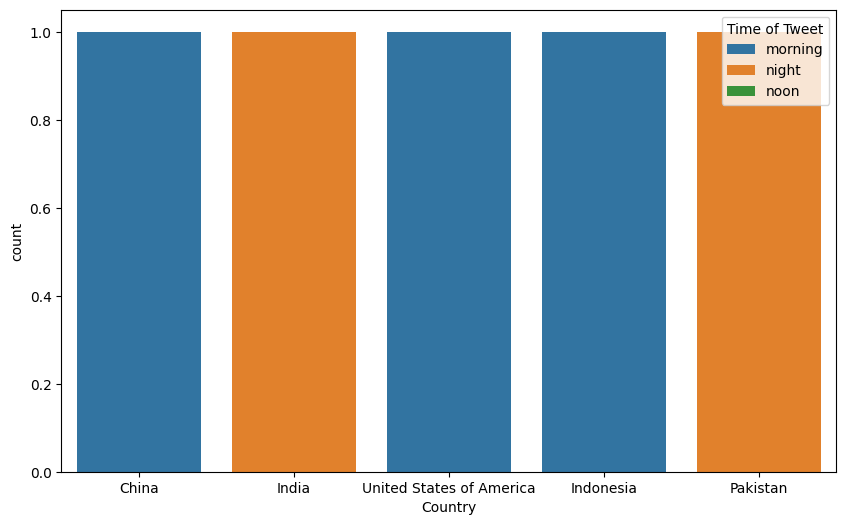

In [14]:
plt.figure(figsize=(10,6))
sns.countplot(data=melt, x=melt['Country'][0:5],hue=melt['Time of Tweet'])

Text(0, 0.5, 'Count')

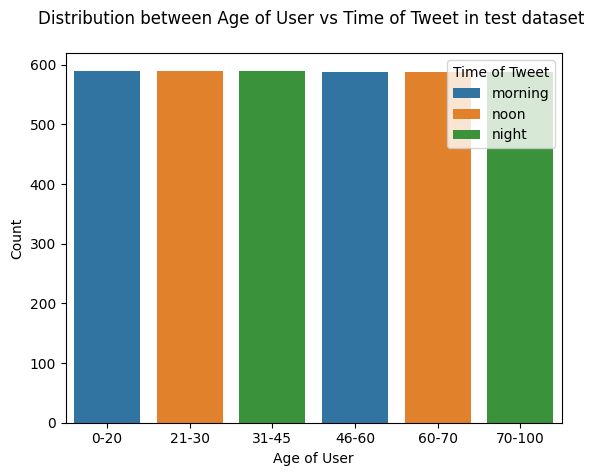

In [15]:
sns.countplot(data=test,x=test['Age of User'],hue=test['Time of Tweet'])
plt.title('Distribution between Age of User vs Time of Tweet in test dataset \n')
plt.xlabel('Age of User')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

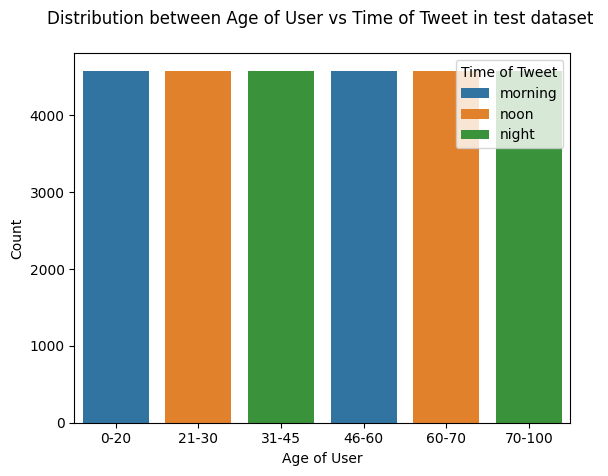

In [16]:
sns.countplot(data=train,x=train['Age of User'],hue=train['Time of Tweet'])
plt.title('Distribution between Age of User vs Time of Tweet in test dataset \n')
plt.xlabel('Age of User')
plt.ylabel('Count')

# Cleanig the Text Column in Both Train and Test Dataset for the Machine Learning Process.


In [17]:
def preprocessing(text):
  text = str(text)# Ensures the input is treated as a string.
  # Uses regular expressions (re.sub) to remove web addresses (URLs) starting with "http" or "www".
  text=re.sub(r'http\S+|www\S+', '', text) # Where S is the non White space Charecter example:\\
  text=re.sub(r'\d+', '', text) # Replacing the digits with empty Character
  text=re.sub(r'[^\w\s]', '', text) # ^:not w: alphanumical Character(letters,numbers,underscore),s:whitespace (space,tabs,newlines)
  text=re.sub(r'\s+', ' ', text)
  text=text.lower()
  text=word_tokenize(text) #This line uses the word_tokenize function from the nltk library to split the input text into individual words, called tokens.
  text=[token for token in text if token not in stopwords.words('english')]
  lemmatizer=nltk.stem.WordNetLemmatizer()# creates a lemmatizer object.
  text=[lemmatizer.lemmatize(token) for token in text]# applied lemmatization By default it is in noun
  text=[lemmatizer.lemmatize(token, pos='v') for token in text]# appling Lemmatization again this time lemmatize word in verd form
  text=' '.join(text)
  return text


In [18]:
train['text'] = train['text'].apply(preprocessing) # Apply the function to each element of the Series


In [19]:
train['text']

,text
0,id respond go
1,sooo sad miss san diego
2,bos bully
3,interview leave alone
4,son couldnt put release already buy
...,...
27476,wish could come see u denver husband lose job ...
27477,ive wonder rake client make clear net dont for...
27478,yay good enjoy break probably need hectic week...
27479,worth


In [20]:
test['text']=test['text'].apply(preprocessing)

In [21]:
test['text']

,text
0,last session day
1,shanghai also really excite precisely skyscrap...
2,recession hit veronique branquinho quit compan...
3,happy bday
4,like
...,...
3529,im tire cant sleep try
3530,alone old house thank net keep alive kick whoe...
3531,know mean little dog sink depression want move...
3532,_sutra next youtube video gon na love video


In [22]:
train['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


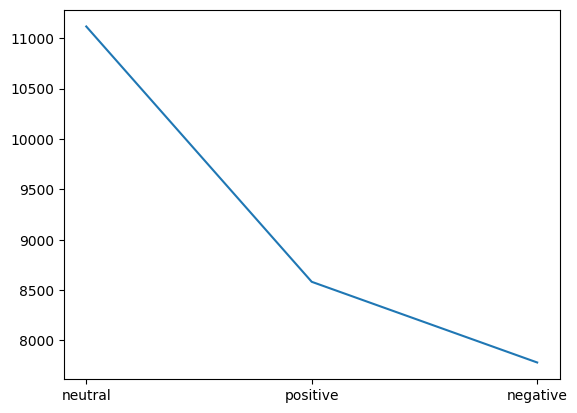

In [23]:
plt.plot(train['sentiment'].value_counts())

In [24]:
test['sentiment'].value_counts()


,count
sentiment,
neutral,1430
positive,1103
negative,1001


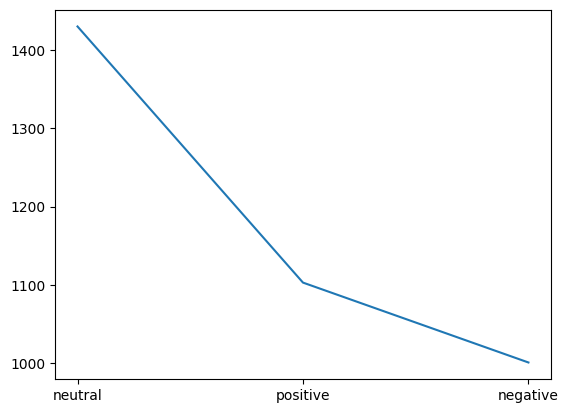

In [25]:
plt.plot(test['sentiment'].value_counts())

In [26]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
train['sentiment']=encoder.fit_transform(train['sentiment'])
test['sentiment']=encoder.transform(test['sentiment'])

In [27]:
print('Train\n\n',train['sentiment'].value_counts(),'\n')
print('Test\n\n',test['sentiment'].value_counts())

Train

 sentiment
1    11117
2     8582
0     7781
Name: count, dtype: int64 

Test

 sentiment
1    1430
2    1103
0    1001
Name: count, dtype: int64


In [28]:
from sklearn.feature_extraction.text  import TfidfVectorizer
vectorizer=TfidfVectorizer(min_df=0.001,ngram_range=(1,2))
train_features=vectorizer.fit_transform(train['text'])
test_features=vectorizer.transform(test['text'])

# LogisticRegression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

model1=LogisticRegression(random_state=42,class_weight='balanced',solver='lbfgs',multi_class='multinomial', n_jobs=-1)
model1.fit(train_features, train['sentiment'])
print(model1.score(train_features, train['sentiment']))
ypred1=model1.predict(test_features)
print(f1_score(test['sentiment'], ypred1, average='macro'))
print(classification_report(test['sentiment'], ypred1))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.7258369723435225
0.7033092098983736
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1001
           1       0.67      0.67      0.67      1430
           2       0.78      0.74      0.76      1103

    accuracy                           0.70      3534
   macro avg       0.70      0.70      0.70      3534
weighted avg       0.70      0.70      0.70      3534



# RandomForestClassifier

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],  # Added to control overfitting
    'max_features': ['sqrt', 'log2', 3],  # Test different feature subsets
    'class_weight': ['balanced', None]  # Test imbalance handling
}
gridsearch=GridSearchCV(RandomForestClassifier(),param_grid=param_grid,cv=5,n_jobs=-1)
gridsearch.fit(train_features, train['sentiment'])
best_params=gridsearch.best_params_
print(best_params)




{'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [49]:
model2 = RandomForestClassifier(
    random_state=42,
    max_depth=20,
    n_estimators=200,
    min_samples_split=2,
    min_samples_leaf=2,
    class_weight='balanced',
    max_features='log2',
    n_jobs=-1
)
model2.fit(train_features, train['sentiment'])
print(model2.score(train_features, train['sentiment']))
ypred2=model2.predict(test_features)
print(f1_score(test['sentiment'], ypred2, average='macro'))
print(classification_report(test['sentiment'], ypred2))

0.6966885007278021
0.6855408778062128
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      1001
           1       0.63      0.71      0.67      1430
           2       0.78      0.70      0.74      1103

    accuracy                           0.68      3534
   macro avg       0.69      0.68      0.69      3534
weighted avg       0.69      0.68      0.68      3534



# Naive Bayes


In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report
model=MultinomialNB()
model.fit(train_features, train['sentiment'])
ypred=model.predict(test_features)
print(f1_score(test['sentiment'], ypred, average='macro'))
print(classification_report(test['sentiment'], ypred))

0.6529353279436249
              precision    recall  f1-score   support

           0       0.75      0.52      0.62      1001
           1       0.57      0.80      0.67      1430
           2       0.79      0.59      0.68      1103

    accuracy                           0.66      3534
   macro avg       0.71      0.64      0.65      3534
weighted avg       0.69      0.66      0.66      3534



# KNeighborsClassifier

In [39]:
from sklearn.neighbors import KNeighborsClassifier

model4=KNeighborsClassifier(n_neighbors=7)
model4.fit(train_features, train['sentiment'])
ypred=model4.predict(test_features)
print(f1_score(test['sentiment'], ypred, average='macro'))
print(classification_report(test['sentiment'], ypred))


0.5093269194670866
              precision    recall  f1-score   support

           0       0.59      0.35      0.44      1001
           1       0.48      0.80      0.60      1430
           2       0.72      0.37      0.48      1103

    accuracy                           0.54      3534
   macro avg       0.60      0.51      0.51      3534
weighted avg       0.59      0.54      0.52      3534



In [34]:
def classification(r):
  predictloss=[]
  for i in r:
    model3=KNeighborsClassifier(n_neighbors=i)
    model3.fit(train_features, train['sentiment'])
    ypred=model3.predict(test_features)
    predictloss.append(f1_score(test['sentiment'], ypred, average='macro'))
  return predictloss



In [35]:
r=range(5,20,2)
f1_scores = classification(r)

Elbow Curve is useful to decide the n_neigbours

Text(0.5, 1.0, 'Elbow Curve')

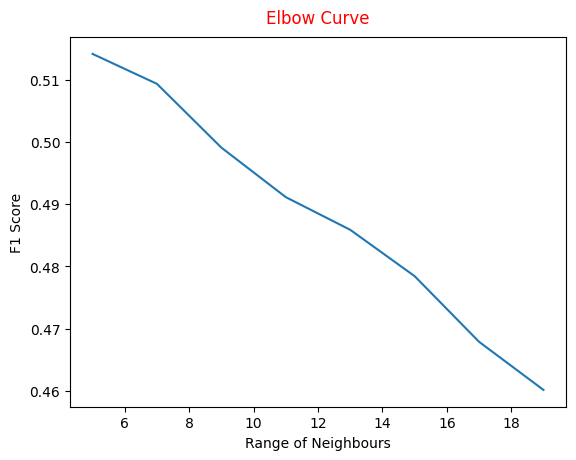

In [36]:
plt.plot(r,f1_scores)
plt.xlabel('Range of Neighbours',size=10)
plt.ylabel('F1 Score',size=10)
plt.title('Elbow Curve',c='r',pad=10)

# xgboost

In [53]:
import xgboost as xgb
Train_data=xgb.DMatrix(train_features,label=train['sentiment'])
Test_data=xgb.DMatrix(test_features,label=test['sentiment'])
params={
    'objective':'multi:softmax',
    'num_class':3,
    'eval_metric':'mlogloss',
    'eta':0.1,
    'max_depth':6,
    'reg_lambda': 1.0,  # L2 regularization
}

model5=xgb.train(params,Train_data,num_boost_round=1000,evals=[(Train_data,'train'), (Test_data,'eval')],early_stopping_rounds=15,verbose_eval=10)          # Print metrics every 10 rounds)
ypred=model5.predict(Test_data)

print(f1_score(test['sentiment'], ypred, average='macro'))
print(classification_report(test['sentiment'], ypred))

[0]	train-mlogloss:1.07624	eval-mlogloss:1.07652
[10]	train-mlogloss:0.95875	eval-mlogloss:0.96361
[20]	train-mlogloss:0.90844	eval-mlogloss:0.91858
[30]	train-mlogloss:0.87575	eval-mlogloss:0.89057
[40]	train-mlogloss:0.85149	eval-mlogloss:0.87147
[50]	train-mlogloss:0.83255	eval-mlogloss:0.85731
[60]	train-mlogloss:0.81665	eval-mlogloss:0.84500
[70]	train-mlogloss:0.80315	eval-mlogloss:0.83500
[80]	train-mlogloss:0.79107	eval-mlogloss:0.82635
[90]	train-mlogloss:0.78041	eval-mlogloss:0.81878
[100]	train-mlogloss:0.77044	eval-mlogloss:0.81215
[110]	train-mlogloss:0.76147	eval-mlogloss:0.80633
[120]	train-mlogloss:0.75316	eval-mlogloss:0.80120
[130]	train-mlogloss:0.74555	eval-mlogloss:0.79584
[140]	train-mlogloss:0.73803	eval-mlogloss:0.79133
[150]	train-mlogloss:0.73127	eval-mlogloss:0.78680
[160]	train-mlogloss:0.72494	eval-mlogloss:0.78288
[170]	train-mlogloss:0.71877	eval-mlogloss:0.77941
[180]	train-mlogloss:0.71297	eval-mlogloss:0.77601
[190]	train-mlogloss:0.70740	eval-mlogloss

# lightgbm

In [64]:
import lightgbm as gbm
from sklearn.metrics import accuracy_score
train_data=gbm.Dataset(train_features,label=train['sentiment'])
test_data=gbm.Dataset(test_features,label=test['sentiment'])

params={
    'objective':'multiclass',
    'num_class':3,
    'num_leaves':64,
    'metric':'multi_logloss',
    'learning_rate':0.1,
    'reg_lambda': 1.0,
}

model6=gbm.train(params,train_data,num_boost_round=100,valid_sets=[train_data,test_data])
ypred=model6.predict(test_features)
ypred=np.argmax(ypred,axis=1)
print(accuracy_score(train['sentiment'], model6.predict(train_features).argmax(axis=1))) # Calculate accuracy on training data
print(f1_score(test['sentiment'], ypred, average='macro'))
print(classification_report(test['sentiment'], ypred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.480099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44975
[LightGBM] [Info] Number of data points in the train set: 27480, number of used features: 1069
[LightGBM] [Info] Start training from score -1.261774
[LightGBM] [Info] Start training from score -0.904983
[LightGBM] [Info] Start training from score -1.163791
0.779075691411936
0.7060761099065914
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      1001
           1       0.65      0.73      0.69      1430
           2       0.78      0.74      0.76      1103

    accuracy                           0.71      3534
   macro avg       0.72      0.70      0.71      3534
weighted avg       0.71      0.71      0.71      3534

